In [1]:
import json
from pathlib import Path

import numpy as np

from tqdm.notebook import tqdm
from ezmsg.util.messagelogger import MessageDecoder

from hololight.shallowfbcspnet import (
    ShallowFBCSPNet, 
    ShallowFBCSPParameters, 
    PreloadedFBCSPDataset, 
    dummy_output
)

from typing import List


In [2]:

samples = []
data_fname = Path( '..' ) / 'recordings' / 'traindata.txt'
with open( data_fname, 'r' ) as data_file:
    samples = [ json.loads( line, cls = MessageDecoder ) for line in data_file ]

eeg_trials = np.array( [ s[ 'sample' ][ 'data' ] for s in samples ] ).swapaxes( 1, 2 )
eeg_labels = np.array( [ int( s[ 'trigger' ][ 'value' ] ) for s in samples ] )

train_dset = ( eeg_trials[:40, ...], eeg_labels[:40, ...] )
test_dset = ( eeg_trials[40:, ...], eeg_labels[40:, ...] )

In [3]:
params = ShallowFBCSPParameters(
    in_chans = eeg_trials.shape[1],
    n_classes = len( np.unique( eeg_labels ) ),
    input_time_length = eeg_trials.shape[2],
    cropped_training = True,
    n_filters_time = 40,
    filter_time_length = 25,
    n_filters_spat = 40,
    pool_time_length = 75,
    pool_time_stride = 15,
    conv_nonlin = 'square',
    pool_mode = 'mean',
    pool_nonlin = 'safe_log',
    split_first_layer = True,
    batch_norm = True,
    batch_norm_alpha = 0.1,
    drop_prob = 0.5,
    single_precision = False
)

net = ShallowFBCSPNet( params )

print( net )

Model: Sequential(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 8), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=_squeeze_final_output)
)
Model has 16322 trainable parameters on device: cpu (cropped training)
When segmenting temporal windows -- use optimal temporal stride of 467 samples
Model input: ( batch x 8 ch x 1000 time points, dtype=torch.float64 )
Model output: ( batch x 2 classes x 467 crops, dtype=to

In [4]:
train_info = net.train( train_dset, test_dset, progress = True )

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Training Curves')

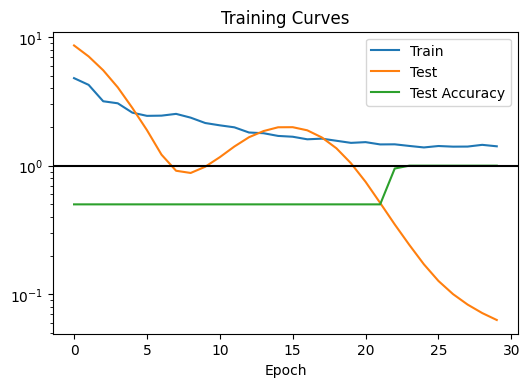

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( dpi = 100, figsize = ( 6.0, 4.0 ) )
ax.plot( [ e.train_loss for e in train_info ], label = 'Train' )
ax.plot( [ e.test_loss for e in train_info ], label = 'Test' )
ax.plot( [ e.test_accuracy for e in train_info ], label = 'Test Accuracy' )
# ax.plot( [ e.lr for e in train_info ], label = 'Learning Rate' )
ax.legend()
ax.set_yscale( 'log' )
ax.set_xlabel( 'Epoch' )
ax.axhline( 1, color = 'k' )
ax.set_title( 'Training Curves' )

Text(0.5, 1.0, 'Classifier Confusion')

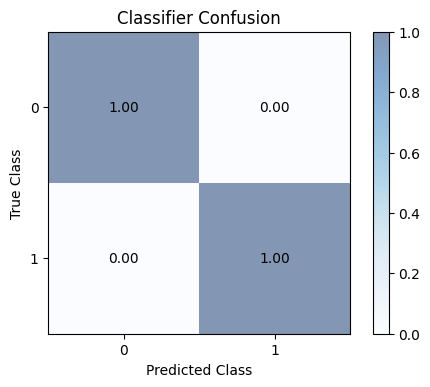

In [6]:
test_feats, test_labels = test_dset
decode = net.inference( test_feats ).argmax( axis = 1 )

classes = list( sorted( set( test_labels ) ) ) 
confusion = np.zeros( ( len( classes ), len( classes ) ) )

for true_idx, true_class in enumerate( classes ):
    class_trials = np.where( np.array( test_labels ) == true_class )[0]
    for pred_idx, pred_class in enumerate( classes ):
        num_preds = ( decode[ class_trials ] == pred_class ).sum().item()
        confusion[ true_idx, pred_idx ] = num_preds / len( class_trials )

fig, ax = plt.subplots( dpi = 100 )
corners = np.arange( len( classes ) + 1 ) - 0.5
im = ax.pcolormesh( 
    corners, corners, confusion, alpha = 0.5,
    cmap = plt.cm.Blues, vmin = 0.0, vmax = 1.0
)

for row_idx, row in enumerate( confusion ):
    for col_idx, freq in enumerate( row ):
        ax.annotate( 
            f'{freq:0.2f}', ( col_idx, row_idx ), 
            ha = 'center', va = 'center' 
        )

ax.set_aspect( 'equal' )
ax.set_xticks( classes )
ax.set_yticks( classes )
ax.set_ylabel( 'True Class' )
ax.set_xlabel( 'Predicted Class' )
ax.invert_yaxis( )
fig.colorbar( im )
ax.set_title( 'Classifier Confusion' )


In [7]:
checkpoint_fname = Path( '.' ) / 'TestFBCSP.checkpoint'
net.save_checkpoint_file( checkpoint_fname )

In [8]:
loaded_net = ShallowFBCSPNet.from_checkpoint_file( checkpoint_fname )

In [9]:
test_feats, test_labels = test_dset[:]
decode = net.inference( test_feats ).argmax( axis = 1 )
print( 'Decoded Output:')
print( decode )
print( 'True Output:' )
print( np.array( test_labels ) )

Decoded Output:
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
True Output:
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
